In [6]:
import numpy as np
from pandas import read_csv
from random import shuffle
from math import floor

import keras
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import sklearn.metrics

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


In [8]:
def evaluate_model(model, X_test, Y_test):
    test_preds = model.predict(X_test)

    test_W = model.predict(X_test[(Y_test == 1).reshape((X_test.shape[0],))])
    test_no = model.predict(X_test[(Y_test == 0).reshape((X_test.shape[0],))])

    print("====All====")
    for name, value in zip(model.metrics_names, test_preds):
        print(name, ': ', value)
    print()

    print("====Wickets only====")
    for name, value in zip(model.metrics_names, test_W):
        print(name, ': ', value)
    print()

    print("====NOs only====")
    for name, value in zip(model.metrics_names, test_no):
        print(name, ': ', value)
    print()

In [17]:
# Load data
X = read_csv("data/fow_ann_X.csv").to_numpy()
Y = read_csv("data/fow_ann_Y.csv").to_numpy()

In [18]:
# Split into training, testing, validation
n_rows = X.shape[0]
shuffle_idx = list(range(n_rows))
shuffle(shuffle_idx)

X = X[shuffle_idx, :]
Y = Y[shuffle_idx, :]

split = (0.8, 0.1, 0.1)
split_idx = (floor(split[0]*n_rows) - 1, floor((split[0] + split[1])*n_rows) - 1)
X_train = X[0:split_idx[0],:]
Y_train = Y[0:split_idx[0],:]
X_val = X[split_idx[0]+1:split_idx[1],:]
Y_val = Y[split_idx[0]+1:split_idx[1],:]
X_test = X[split_idx[1]+1:,:]
Y_test = Y[split_idx[1]+1:,:]

## Baseline Model - Proportions

In [14]:
class PropModel:
    def __init__(self, Y, metrics):
        self.Wprop = np.sum(Y)/(Y.shape[0])
        self.metrics_names = metrics
    
    def predict(self, X, **kwargs):
        return self.Wprop * np.ones(X.shape)

In [15]:
prop_model = PropModel(Y_train, METRICS)

In [16]:
# Evaluate
evaluate_model(prop_model, X_test, Y_test)

====All====
<tensorflow.python.keras.metrics.TruePositives object at 0x000001EBEF0DE188> :  [0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188]
<tensorflow.python.keras.metrics.FalsePositives object at 0x000001EBEF104548> :  [0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188
 0.01640188 0.01640188 0.01640188 0.01640188 0.01640188

## Model

In [19]:
nW = np.sum(Y_train)
nno = Y.shape[0] - nW
initial_bias = np.log([nW/nno])
output_bias = keras.initializers.Constant(initial_bias)

total = nW + nno
weight_for_0 = (1 / nno)*(total)/2.0 
weight_for_1 = (1 / nW)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))

In [20]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=METRICS)

In [21]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), class_weight=class_weight)

Epoch 1/50
10590/10590 [==============================] - 15s 1ms/step - loss: 0.8185 - tp: 7346.0000 - fp: 424585.0000 - tn: 242049.0000 - fn: 3747.0000 - accuracy: 0.3680 - precision: 0.0170 - recall: 0.6622 - auc: 0.5315 - prc: 0.0189 - val_loss: 0.6642 - val_tp: 678.0000 - val_fp: 29057.0000 - val_tn: 54209.0000 - val_fn: 771.0000 - val_accuracy: 0.6479 - val_precision: 0.0228 - val_recall: 0.4679 - val_auc: 0.5775 - val_prc: 0.0238
Epoch 2/50
10590/10590 [==============================] - 14s 1ms/step - loss: 0.8117 - tp: 8199.0000 - fp: 462798.0000 - tn: 203836.0000 - fn: 2894.0000 - accuracy: 0.3129 - precision: 0.0174 - recall: 0.7391 - auc: 0.5513 - prc: 0.0212 - val_loss: 0.8389 - val_tp: 1295.0000 - val_fp: 75265.0000 - val_tn: 8001.0000 - val_fn: 154.0000 - val_accuracy: 0.1097 - val_precision: 0.0169 - val_recall: 0.8937 - val_auc: 0.5345 - val_prc: 0.0194
Epoch 3/50
10590/10590 [==============================] - 14s 1ms/step - loss: 0.7899 - tp: 7165.0000 - fp: 424049.000

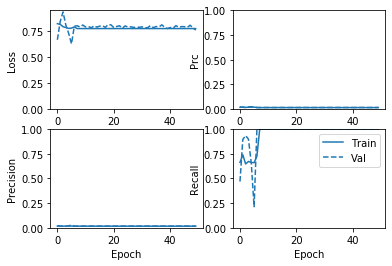

In [22]:
plot_metrics(history)

In [24]:
test_preds = model.predict(X_test, batch_size=2048)

test_W = model.predict(X_test[(Y_test == 1).reshape((X_test.shape[0],))], batch_size=2048)
test_no = model.predict(X_test[(Y_test == 0).reshape((X_test.shape[0],))], batch_size=2048)

for name, value in zip(model.metrics_names, test_preds):
  print(name, ': ', value)
print()

print("====Wickets only====")
for name, value in zip(model.metrics_names, test_W):
  print(name, ': ', value)
print()

print("====NOs only====")
for name, value in zip(model.metrics_names, test_no):
  print(name, ': ', value)
print()

#plot_roc("Test Baseline", Y_test, test_preds)

loss :  [0.53179353]
tp :  [0.53179353]
fp :  [0.53179353]
tn :  [0.53179353]
fn :  [0.53179353]
accuracy :  [0.53179353]
precision :  [0.53179353]
recall :  [0.53179353]
auc :  [0.53179353]
prc :  [0.53179353]

====Wickets only====
loss :  [0.53179353]
tp :  [0.53179353]
fp :  [0.53179353]
tn :  [0.53179353]
fn :  [0.53179353]
accuracy :  [0.53179353]
precision :  [0.53179353]
recall :  [0.53179353]
auc :  [0.53179353]
prc :  [0.53179353]

====NOs only====
loss :  [0.53179353]
tp :  [0.53179353]
fp :  [0.53179353]
tn :  [0.53179353]
fn :  [0.53179353]
accuracy :  [0.53179353]
precision :  [0.53179353]
recall :  [0.53179353]
auc :  [0.53179353]
prc :  [0.53179353]

